To run a cell, type `Shift` + `Return`. Run the cell below to get started

In [2]:
from workshop_utils import * 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# All Edits Example



The following query gets all of the edits (ever), joined to changesets for all objects in Haiti... it should take some time to download.

```sql
SELECT
  central_america.id, 
  geom,
  central_america.tags, changeset, updated, valid_until, version, minor_version,
  changesets.id AS c_id, 
  changesets.tags as c_tags,
  changesets.uid,
  changesets.user
  
FROM central_america

JOIN changesets on central_america.changeset = changesets.id

WHERE ST_WITHIN(
  geom , 
  ST_Polygon('POLYGON((-74.4862 20.1269, -71.5923 20.1269, -71.5923 17.9824, -74.4862 17.9824, -74.4862 20.1269))')
)```

In [3]:
edits = load_dataframe_from_s3('https://us-east-2.console.aws.amazon.com/athena/query/results/9362c8f9-7eac-4e1e-b490-c1eceef793cf/csv')


data/9362c8f9-7eac-4e1e-b490-c1eceef793cf.csv
Creating dataframe... done.  Found 2,600,449 rows

In [4]:
edits.head(2)

,id,geom,tags,changeset,updated,valid_until,version,minor_version,c_id,c_tags,uid,user
0,446656878,"LINESTRING (-73.1947951 18.3745085, -73.195015...","{source=bing, highway=residential}",42752453,2016-10-09 11:57:21.000,2019-05-28 02:55:06.000,1,0,42752453,{comment=#hotosm-project-2203 #HurricaneMatthe...,1056443,pm5
1,216532037,"POLYGON ((-72.1595581 19.6925434, -72.1595605 ...","{source=Bing, building=yes}",15659323,2013-04-08 20:25:02.000,2013-04-09 19:57:44.000,1,0,15659323,{comment=CAP103 ajout de bâtiments à quartier-...,231539,Xapitoun


In [8]:
#Cast the date as date
edits['updated'] = edits.updated.apply(pd.Timestamp)

In [10]:
edits['date'] = edits.updated.apply(pd.Timestamp.date)

In [13]:
gb_date = edits.groupby('date').aggregate({
    'c_id':'count',
    'id':'nunique',
    'uid':'nunique'
});
gb_date.head(2)

,c_id,id,uid
date,,,
2007-03-18,1,1,1
2007-10-30,449,449,1


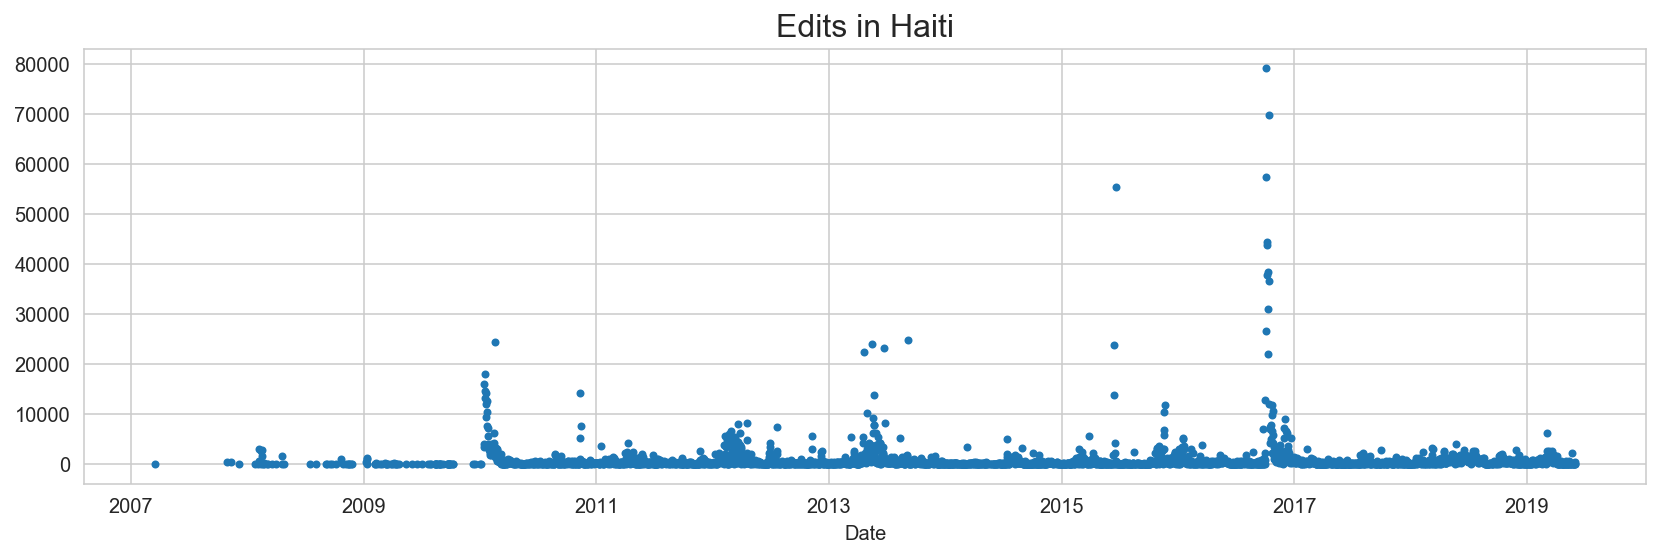

In [16]:
sns.set_style('whitegrid')
ax = gb_date['c_id'].plot(style='.', figsize=(14,4))
ax.set_xlabel("Date"); ax.set_ylabel("");
ax.set_title("Edits in Haiti",fontsize=16);

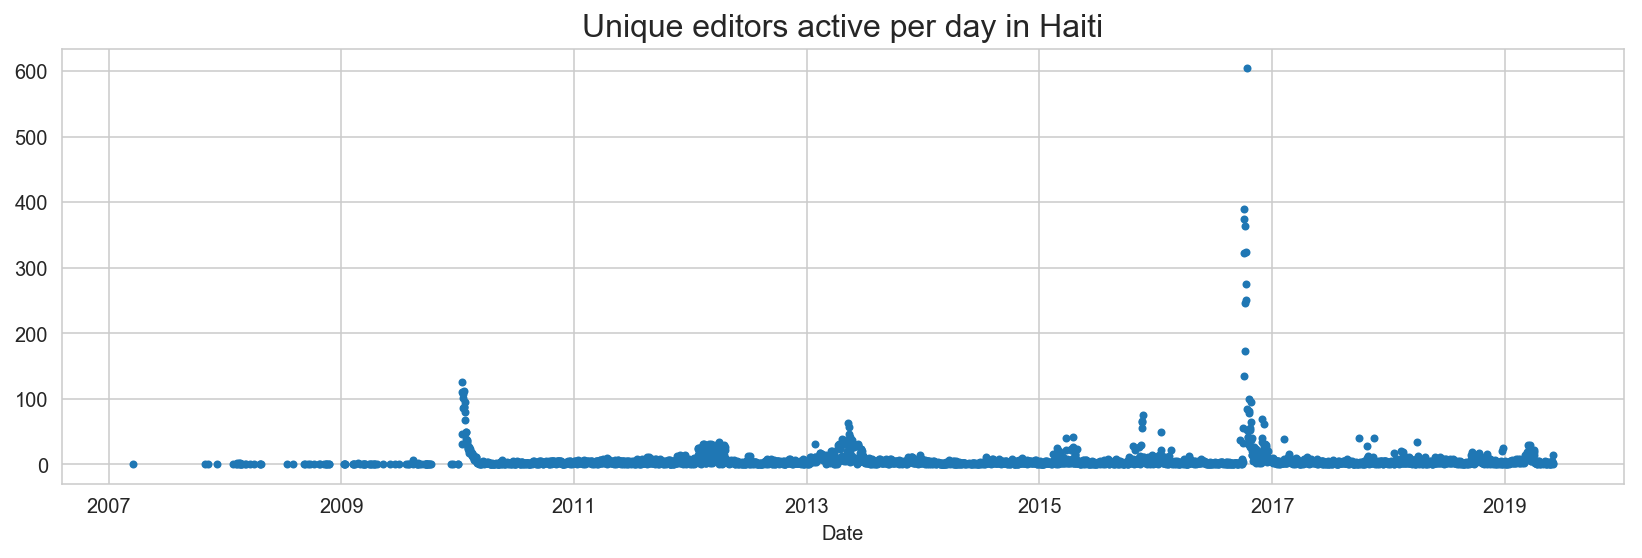

In [19]:
sns.set_style('whitegrid')
ax = gb_date['uid'].plot(style='.', figsize=(14,4))
ax.set_xlabel("Date"); ax.set_ylabel("");
ax.set_title("Unique editors active per day in Haiti",fontsize=16);

### `Minor Version`

We can use the `minor version` attribute to identify geometry updates to buildings. This can be a form of validation behavior. identifying spikes in the occurence of these can identify map validation.

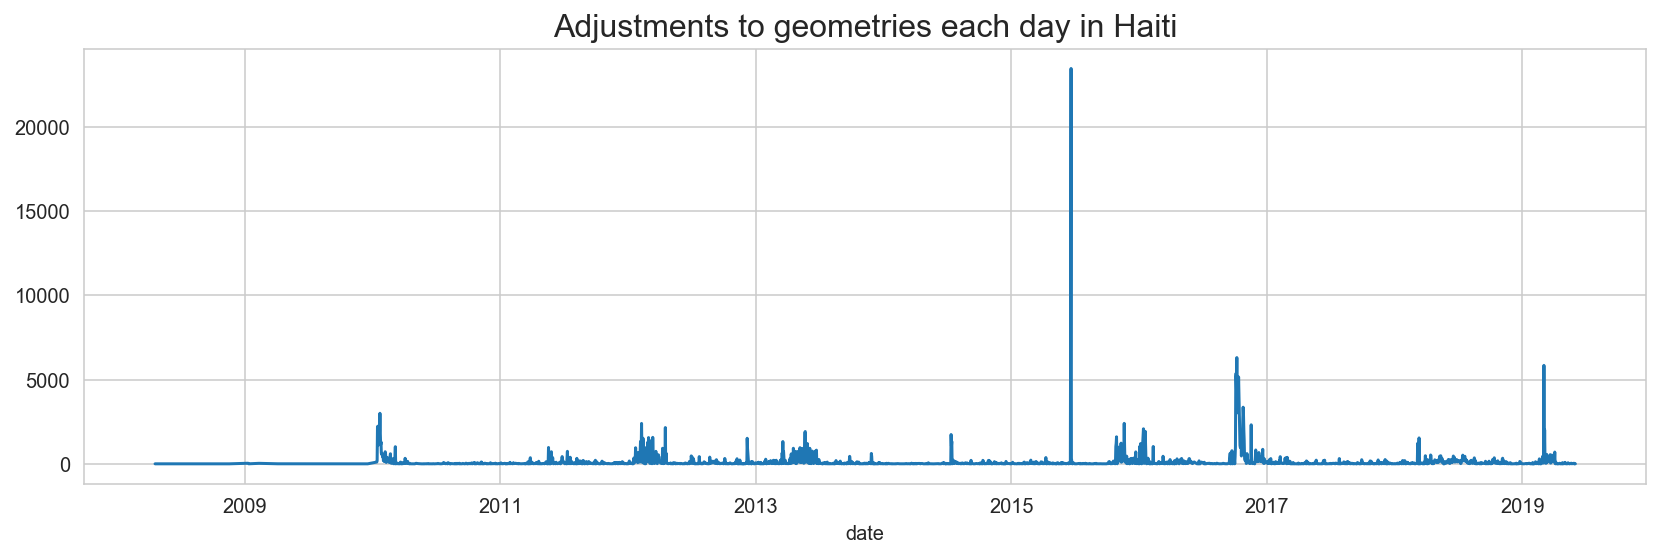

In [20]:
ax = edits[edits.minor_version>0].groupby('date').aggregate('count')['id'].plot(figsize=(14,4))
ax.set_title("Adjustments to geometries each day in Haiti",fontsize=16);

What is the most edited object? 

In [21]:
# This is a bit hacky, but it definitely works
most_edited_object = pd.DataFrame(edits[edits.id==edits.sort_values(
    by='version',ascending=False).id.values[0]].sort_values(
      by=['version','minor_version'],ascending=False))

print("most edited building: http://openstreetmap.org/way/{}\nThe most recent three edits:".format(most_edited_object.id.values[0]))

most_edited_object.head(3)

most edited building: http://openstreetmap.org/way/48367858
The most recent three edits:


,id,geom,tags,changeset,updated,valid_until,version,minor_version,c_id,c_tags,uid,user,date
2565957,48367858,"LINESTRING (-74.1432913 18.6616449, -74.143402...",{natural=coastline},68398284,2019-03-22 06:14:32,NaN,125,0,68398284,"{comment=Snapped beach to coastline, source=Bi...",8076764,Tauntaun,2019-03-22
1173423,48367858,"LINESTRING (-74.1432913 18.6616449, -74.143402...",{natural=coastline},68397641,2019-03-22 05:39:50,2019-03-22 06:14:32.000,124,0,68397641,"{comment=Aligned coastline feature, source=Bin...",8076764,Tauntaun,2019-03-22
495129,48367858,"LINESTRING (-74.1432913 18.6616449, -74.143402...",{natural=coastline},66127457,2019-01-08 12:49:34,2019-03-22 05:39:50.000,123,0,66127457,"{host=https://www.openstreetmap.org/edit, imag...",212507,absinthologue,2019-01-08
